In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import sympy as sp
from IPython.display import clear_output
input_dim = 3

operators_uni = [
    "sin", "cos", "abs", "sqrt", "ln", "exp", "", "square"
]
operators_uni = [
    "sin", "cos", "sqrt", "", "square","zeroise"
]
operators_bin = [ "+", "-", "*", "/"]

#variables = ["const"] + [f"x{i}" for i in range(input_dim)]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def combine(x, bin=True):
    if bin:
        return len(operators_bin) * x ** 2 - (len(operators_bin) - 1) * x
    else:
        return len(operators_uni) * x 

In [3]:
def var_gen(n_var):
    return [f"x{i}" for i in range(n_var)]
def uni_gen(n_var):
    var = [i for i in range(n_var)]
    op = []
    for _i in var:
        for _j in operators_uni:
                op.append([_j, _i])
    return op
    
def bin_gen(n_var):
    variables = [i for i in range(n_var)]
    op = []
    for i_ in operators_bin:
        for j_ in variables:
            for k_ in variables:
                if (i_ == "/") and (j_ == k_):
                    pass
                elif (i_ == "-") and (j_ == k_):
                    pass
                elif (i_ == "+") and (j_ == k_):
                    pass
                elif (i_ == "*") and (j_ == k_):
                    pass
                else:
                    op.append([j_, i_, k_])
    op += [[i] for i in variables]
    return op

def bin_(op, x):
    if len(op) == 3:
        a, op, b = op[0], op[1], op[2]
        if op == "/":
            return x[:, a] / (x[:, b] + 0.01)
        elif op == "+":
            return x[:, a] + x[:, b]
        elif op == "*":
            return x[:, a] * x[:, b]
        elif op == "-":
            return x[:, a] - x[:, b]
    else:
        return x[:, op[0]]
def uni_(op, x):
    op, a = op[0], op[1]
    if op == "cos":
        return torch.cos(x[:, a])
    elif op == "sin":
        return torch.sin(x[:, a])
    elif op == "abs":
        return torch.abs(x[:, a])
    elif op == "ln":
        return torch.log(torch.abs(x[:, a]))
    elif op == "sqrt":
        return torch.sqrt(torch.abs(x[:, a]))
    elif op == "exp":
        return torch.exp(x[:, a])
    elif op == "square":
        return torch.square(x[:, a])
    elif op == "":
        return x[:, a]
    elif op=="zeroise":
        return torch.zeros_like(x[:,a])

def select(x, i, proba, current_var,  bin=True):
    if bin:
        operations = bin_gen(current_var)
    else:
        operations = uni_gen(current_var)
    output = torch.Tensor([]).to(device)
    output_var = torch.Tensor([]).to(device)
    for op in operations:
        if bin:
            out = bin_(op, x)
        else:
            out = uni_(op, x)
        output_var = torch.cat((output_var, out.unsqueeze(1)), 1)
    output = torch.Tensor([]).to(device)
    for var_ in range(proba.size()[1]):
        out_ = torch.sum(torch.mul(proba[:, var_, :], output_var), dim=1)
        output = torch.cat((output, out_.unsqueeze(1)), 1)
    return output

def select_argmax(x, proba, current_var,  bin=True):
    proba_argmax = np.zeros_like(proba.cpu().detach().numpy())
    max_indices = np.argmax(proba.cpu().detach().numpy(), axis=2)
    # Setting the corresponding indices to 1
    proba_argmax[np.arange(proba.shape[0])[:, None, None],
               np.arange(proba.shape[1])[None, :, None],
               max_indices[:, :, None]] = 1

    proba_argmax = torch.Tensor(proba_argmax)
    #print("PROB SHAPE", proba.shape)
    #print("Arg SHAPE", proba_argmax.shape)

    if bin:
        operations = bin_gen(current_var)
    else:
        operations = uni_gen(current_var)
    output = torch.Tensor([]).to(device)
    output_var = torch.Tensor([]).to(device)
    for op in operations:
        if bin:
            out = bin_(op, x)
        else:
            out = uni_(op, x)
        output_var = torch.cat((output_var, out.unsqueeze(1)), 1)
    output = torch.Tensor([]).to(device)
    for var_ in range(proba_argmax.size()[1]):
        out_ = torch.sum(proba_argmax[:, var_, :].to(device) * output_var, dim=1)
        output = torch.cat((output, out_.unsqueeze(1)), 1)
    return output

In [4]:
def form(proba, i, model, bin=True, k=0):
    pr_ = torch.mean(proba, dim=0)
    if bin:
        vars = bin_gen(model[i])
    else:
        vars = uni_gen(model[i])
    idx = []
    for c in range(model[i + 1]):
            idx.append(torch.argsort(pr_[c], descending=True)[k])
    formula = [vars[l.detach().cpu()] for l in idx]
    return formula

In [5]:
import torch.nn as nn

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

In [6]:
def filter_k_largest(tensor, k):
    # Get the K largest values along the third axis
    k_largest_values, _ = torch.topk(tensor, k, dim=2, largest=True, sorted=True)

    # Create a mask where values less than the Kth largest are set to 0
    mask = tensor < k_largest_values[:, :, -1].unsqueeze(2)

    # Apply the mask to zero out values less than the Kth largest
    filtered_tensor = tensor.masked_fill(mask, 0)

    return filtered_tensor
def replicate_mean(tensor, k):
    # Calculate the mean along the first axis
    mean = torch.mean(tensor, dim=0, keepdim=True)
    # Apply the mask to zero out values less than the Kth largest
    filtered_mean = filter_k_largest(mean, k)
    # Replicate the mean to create a tensor of the same size as the original tensor
    replicated_mean = filtered_mean.repeat(tensor.shape[0], 1, 1)
    return replicated_mean
def normalize_probabilities(tensor):
    # Calculate the sum of probabilities less than 1
    sum_probs = torch.sum(tensor[tensor < 1])

    # Normalize probabilities to sum up to 1
    normalized_tensor = torch.where(tensor < 1, tensor / sum_probs, tensor)

    return normalized_tensor

In [7]:
class Formuler(nn.Module):
    def __init__(self, model):
        super(Formuler, self).__init__()
        self.model = model
        self.encoders = nn.ModuleList()

        for i in range(len(model)-1):
                    odd = i % 2 != 0
                    in_dim = model[i]
                    out_dim = combine(model[i], bin=odd) * model[i + 1]
                    encoder = nn.Sequential(
                        nn.Linear(in_dim, out_dim * 4),
                        nn.ReLU(),
                        nn.Linear(out_dim * 4, out_dim),
                        nn.Linear(out_dim, out_dim),
                        nn.Softmax(dim=1)
                    )
                    self.encoders.append(encoder)


    def forward(self, x):
        formula = []
        for i, encoder in enumerate(self.encoders):
            proba = encoder(x)
            proba = proba.view(-1, self.model[i + 1], proba.size()[1] // self.model[i + 1])
            x = select(x, i, proba, self.model[i], bin=(i % 2 != 0))
            f = form(proba, i, self.model, bin=(i % 2 != 0))
            formula.append(f)
        return x, formula
    def forward_kmax(self, x, k=2, replicate=True):
        formula = []
        probas = []
        for i, encoder in enumerate(self.encoders):
            proba = encoder(x)
            proba = proba.view(-1, self.model[i + 1], proba.size()[1] // self.model[i + 1])
            proba = filter_k_largest(proba, k)
            if replicate == True:
                proba = replicate_mean(proba, k)
            x = select(x, i, proba, self.model[i], bin=(i % 2 != 0))
            f = form(proba, i, self.model, bin=(i % 2 != 0))
            probas.append(proba)
            formula.append(f)
        return x, formula, probas
    def forward_test(self, x):
            formula = []
            probas = []
            for i, encoder in enumerate(self.encoders):
                proba = encoder(x)
                proba = proba.view(-1, self.model[i + 1], proba.size()[1] // self.model[i + 1])
                x = select(x, i, proba, self.model[i], bin=(i % 2 != 0))
                f = form(proba, i, self.model, bin=(i % 2 != 0))
                formula.append(f)
                probas.append(proba)
            return x, formula, probas


In [8]:
def decode(formula, x):
    for i in range(len(formula)):
        out = torch.Tensor([]).to(device)
        for f in formula[i]:
            if (i % 2 == 0):
                out_ =  uni_(f, x).unsqueeze(1)
            else:
                out_ =  bin_(f, x).unsqueeze(1)
            out = torch.cat((out, out_), 1)
        x = out
    return x

In [9]:
model = [3, 3, 2, 2, 1]
# Generate random data
x = np.random.rand(10000, model[0])

size_normal = 10000
size_uniform = 10000
size_exponential = 10000

data_normal = np.random.normal(0, 1, size_normal)
data_uniform = np.random.uniform(-5, 5, size_uniform)
data_exponential = np.random.exponential(1, size_exponential)

x = np.array([data_normal, data_uniform, data_exponential]).T

y = x[:, 1] ** 2 + x[:, 0] + np.cos(x[:, 2])
# Convert to PyTorch tensors
labels = torch.tensor(y, dtype=torch.float32)
features = torch.tensor(x, dtype=torch.float32)

# Create a TensorDataset
my_dataset = TensorDataset(features, labels)

# Create a DataLoader
batch_size = 64
my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)
# Instantiate Formuler and set up optimizer
formuler = Formuler(model).to(device)
optimizer = optim.Adam(formuler.parameters(), lr=0.001)
num_epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
criterion = torch.nn.MSELoss()
# Example usage in a training loop
results = []
formulas = set()
for epoch in range(num_epochs):
    losses = []
    w_losses = []
    formula_losses = []
    for batch_features, batch_labels in my_dataloader:
        # Your training code here
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        output, formula = formuler(batch_features)
        formula_out = decode(formula, batch_features)
        loss_formula = criterion(formula_out.squeeze(1).requires_grad_(), batch_labels)
        formula = " , ".join([' '.join(str(k) for k in j) for i in formula for j in i])
        loss = criterion(output.squeeze(1).requires_grad_(), batch_labels)
        w_loss = loss + 0 * loss_formula
        #print(loss, not torch.isnan(loss))
        formulas.add(formula)
        losses.append(loss)
        w_losses.append(w_loss)
        w_loss.backward()
        optimizer.step()
        scheduler.step()
        formula_losses.append(loss_formula)
    print(f"EPOCH[{epoch}] loss:{sum(losses) / len(losses):.4f}, weighted_loss:{sum(w_losses) / len(w_losses):.4f}, formula_loss:{sum(formula_losses) / len(formula_losses):.4f}, n_explored_formulas:{len(formulas)}, formula : ({formula})")

EPOCH[0] loss:43.2632, weighted_loss:43.2632, formula_loss:716963.1250, n_explored_formulas:20, formula : (square 1 , square 1 , square 2 , 0 + 1 , 1 / 2 ,  0 , square 0 , 0 + 1)
EPOCH[1] loss:1.1295, weighted_loss:1.1295, formula_loss:715171.3750, n_explored_formulas:20, formula : (square 1 , square 1 , square 2 , 0 + 1 , 1 / 2 ,  0 , square 0 , 0 + 1)
EPOCH[2] loss:0.5972, weighted_loss:0.5972, formula_loss:12442081.0000, n_explored_formulas:21, formula : (square 1 , square 1 , square 2 , 1 / 2 , 1 / 2 ,  0 , square 0 , 0 + 1)
EPOCH[3] loss:0.3934, weighted_loss:0.3934, formula_loss:1961980288.0000, n_explored_formulas:23, formula : (square 1 , square 1 , square 0 , 1 / 2 , 1 / 2 ,  0 , square 0 , 0 + 1)
EPOCH[4] loss:0.3048, weighted_loss:0.3048, formula_loss:372872192.0000, n_explored_formulas:23, formula : (square 1 , square 1 , square 2 , 0 + 1 , 1 / 2 ,  0 , square 0 , 0 + 1)
EPOCH[5] loss:0.2116, weighted_loss:0.2116, formula_loss:717871.2500, n_explored_formulas:23, formula : 

tensor(0.0731)
torch.Size([10000, 3])


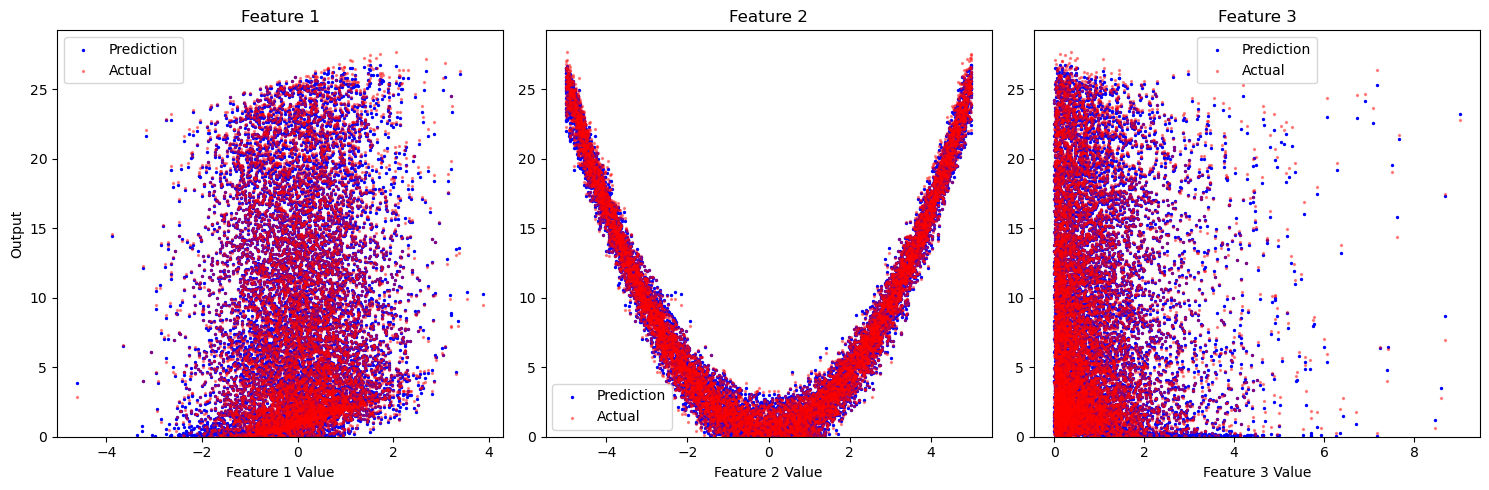

In [11]:
import matplotlib.pyplot as plt

x, formula = formuler(features.to(device))

x = x.detach().cpu()
print(criterion(x.squeeze(1), labels))
print(features.shape)

# Creating a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
size = 2
alpha = 0.4
# Assuming features has at least 3 columns
# Adjust the indices as needed to plot different features

# Scatter plot for feature 1
axes[0].scatter(features[:, 0], x, color="blue", label='Prediction', s=size)
axes[0].scatter(features[:, 0], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[0].set_title('Feature 1')
axes[0].set_xlabel('Feature 1 Value')
axes[0].set_ylabel('Output')
axes[0].set_ylim(0)
axes[0].legend()

# Scatter plot for feature 2
axes[1].scatter(features[:, 1], x, color="blue", label='Prediction', s=size)
axes[1].scatter(features[:, 1], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[1].set_title('Feature 2')
axes[1].set_xlabel('Feature 2 Value')
axes[1].set_ylim(0)
axes[1].legend()

# Scatter plot for feature 3
axes[2].scatter(features[:, 2], x, color="blue", label='Prediction', s=size)
axes[2].scatter(features[:, 2], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[2].set_title('Feature 3')
axes[2].set_xlabel('Feature 3 Value')
axes[2].set_ylim(0)
axes[2].legend()


# Adjust the layout
plt.tight_layout()
plt.show()


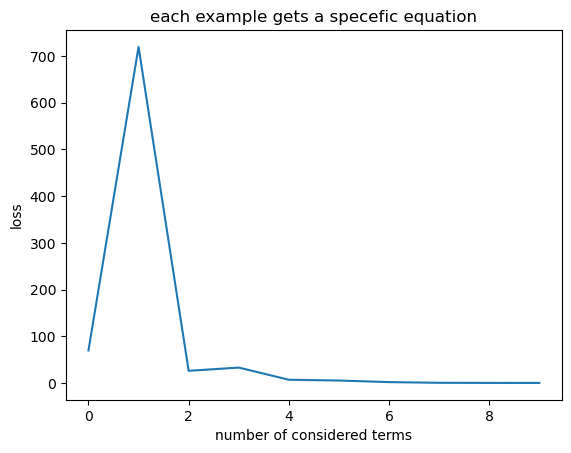

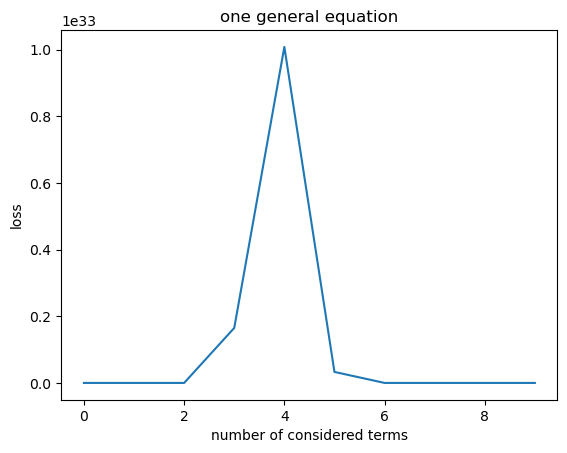

In [19]:
plt.figure()
m = 0
loss_op = []
for i in range(1, 11):
    x, formula, probas = formuler.forward_kmax(features.to(device), k=i, replicate=False)
    x = x.detach().cpu()
    loss_op.append(criterion(x.squeeze(1), labels))
plt.plot(loss_op[m:])
plt.xlabel("number of considered terms")
plt.ylabel("loss")
plt.title("each example gets a specefic equation")
plt.show()
plt.figure()
loss_op = []
for i in range(1, 11):
    x, formula, probas = formuler.forward_kmax(features.to(device), k=i, replicate=True)
    x = x.detach().cpu()
    loss_op.append(criterion(x.squeeze(1), labels))
plt.plot(loss_op[m:])
plt.xlabel("number of considered terms")
plt.ylabel("loss")
plt.title("one general equation")
plt.show()


tensor(0.1930)


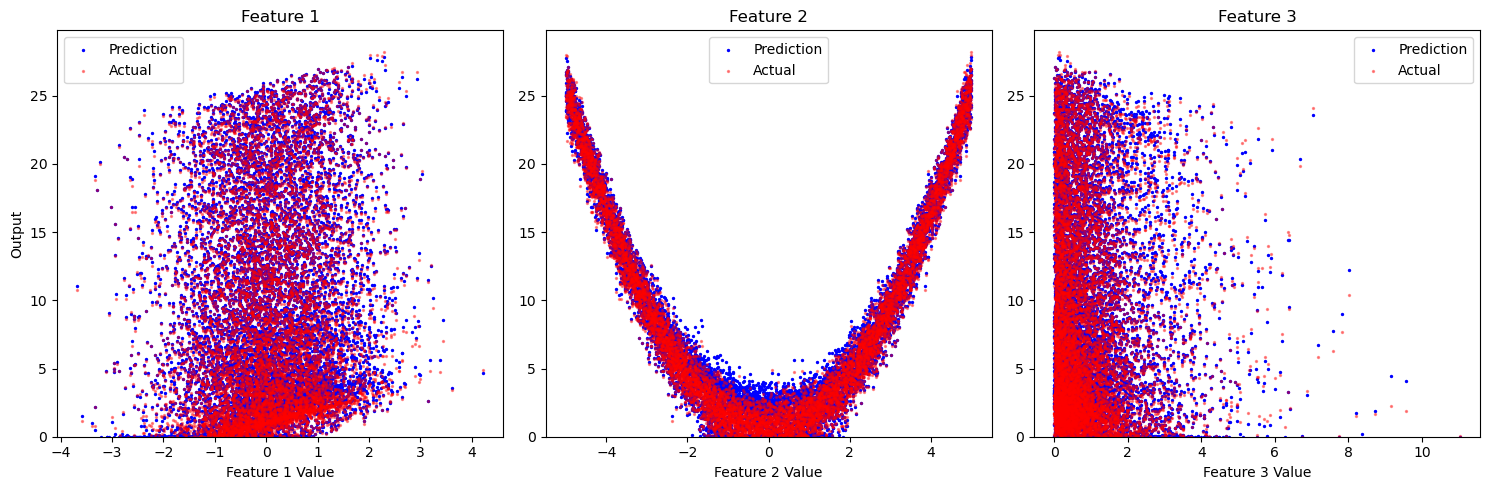

In [ ]:
import matplotlib.pyplot as plt

x, formula= formuler.forward_kmax(features.to(device), k=10, replicate=False)
x = x.detach().cpu()
print(criterion(x.squeeze(1), labels))
# Creating a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
size = 2
alpha = 0.4
# Assuming features has at least 3 columns
# Adjust the indices as needed to plot different features

# Scatter plot for feature 1
axes[0].scatter(features[:, 0], x, color="blue", label='Prediction', s=size)
axes[0].scatter(features[:, 0], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[0].set_title('Feature 1')
axes[0].set_xlabel('Feature 1 Value')
axes[0].set_ylabel('Output')
axes[0].set_ylim(0)
axes[0].legend()

# Scatter plot for feature 2
axes[1].scatter(features[:, 1], x, color="blue", label='Prediction', s=size)
axes[1].scatter(features[:, 1], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[1].set_title('Feature 2')
axes[1].set_xlabel('Feature 2 Value')
axes[1].set_ylim(0)
axes[1].legend()

# Scatter plot for feature 3
axes[2].scatter(features[:, 2], x, color="blue", label='Prediction', s=size)
axes[2].scatter(features[:, 2], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[2].set_title('Feature 3')
axes[2].set_xlabel('Feature 3 Value')
axes[2].set_ylim(0)
axes[2].legend()


# Adjust the layout
plt.tight_layout()
plt.show()


### Search space

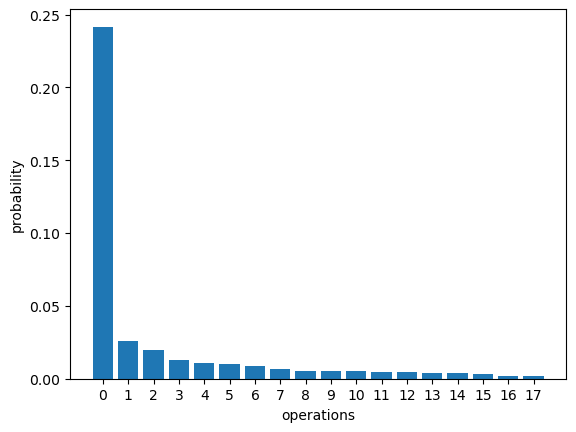

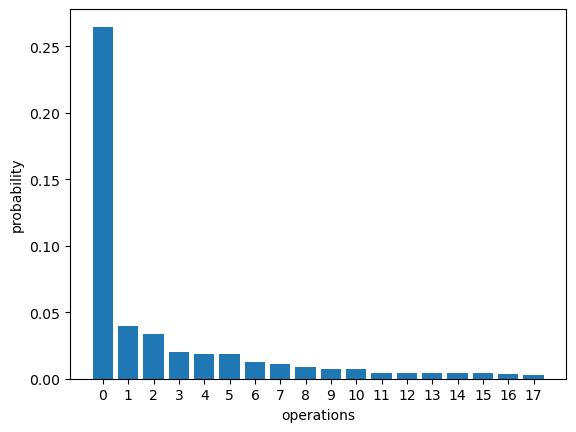

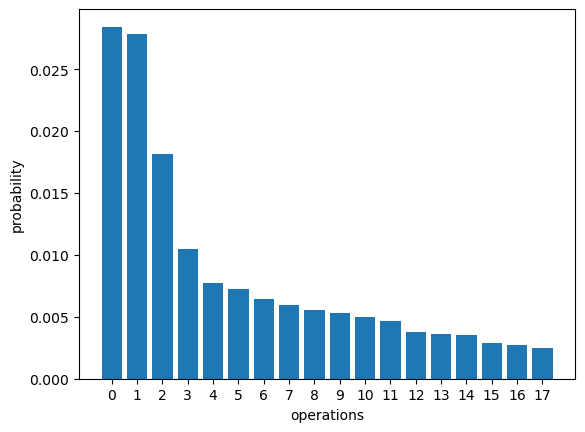

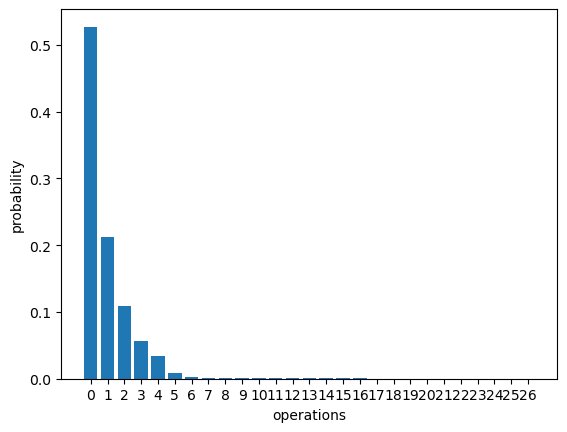

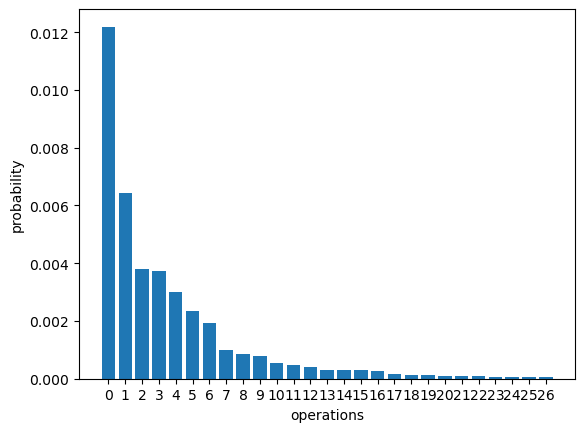

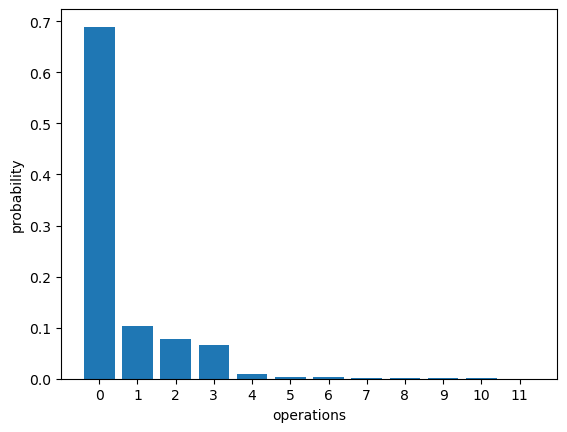

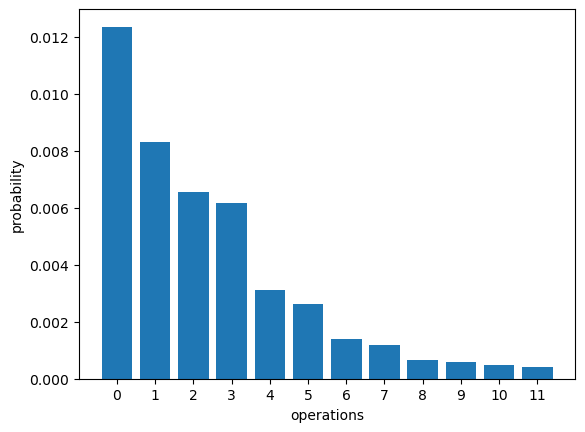

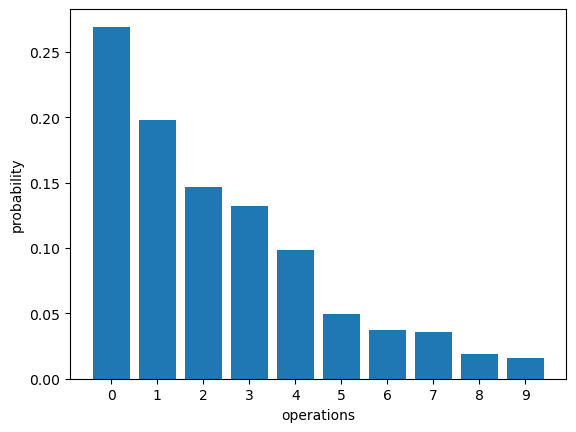

In [ ]:
_, formula, probas = formuler.forward_test(features.to(device))
for m in range(len(probas)):
    proba = probas[m]
    bin = (m % 2 != 0)
    proba = torch.mean(proba, dim=0).detach().cpu()
    for i in range(proba.size()[0]):
        t = [str(k) for k in range(proba[i].size()[0])]
        x, _ = torch.sort(proba[i], dim=0, descending=True)
        plt.figure()
        plt.bar(t, x)
        plt.ylabel("probability")
        plt.xlabel("operations")
        plt.savefig(f"plot/plot{m}-{i}.pdf")

In [ ]:
def split_vector(vector, shape):
    result = []
    start_index = 0
    for size in shape:
        end_index = start_index + size
        result.append(vector[start_index:end_index])
        start_index = end_index
    return result


In [ ]:
_, formula, probas = formuler.forward_test(features.to(device))
prob_size = 3
formula_space = []
for m in range(len(probas)):
    proba = probas[m]
    space = [form(proba, m, model, bin=(m % 2 != 0), k=k) for k in range(prob_size)]
    s = []    
    for i in range(len(space[0])):
        op_ = [s_[i] for s_ in space]
        op_ = list(set(tuple(inner_list) for inner_list in  op_))
        op_ = [list(inner_tuple) for inner_tuple in op_]
        s.append(op_)
    formula_space.append(s)
formula_space

[[[['sqrt', 0], ['square', 1], ['square', 2]],
  [['', 2], ['square', 1], ['cos', 2]],
  [['zeroise', 0], ['square', 1], ['square', 2]]],
 [[[0, '/', 2], [1, '+', 0], [1, '/', 2]],
  [[0, '/', 2], [0, '*', 1], [1, '/', 0]]],
 [[['sqrt', 1], ['square', 1], ['', 0]], [['sqrt', 1], ['sin', 1], ['', 0]]],
 [[[0], [0, '-', 1], [0, '+', 1]]]]

In [ ]:
import itertools
from tqdm import tqdm

# Generate and print all possible n-base vectors of size k
losses = []
for_ = []

# Define the tqdm wrapper
for vector in tqdm(itertools.product(range(prob_size), repeat=sum(model[1:])), desc="Processing Vectors", unit="vector"):
    _f = [
        [
            formula_space[i][j][split_vector(vector, model[1:])[i][j]]
            for j in range(len(split_vector(vector, model[1:])[i]))
        ]
        for i in range(len(formula_space))
    ]
    out = decode(_f, features.to(device))
    loss_f = criterion(out.squeeze(1), labels.to(device)).detach().cpu()
    losses.append(float(loss_f))
    for_.append(_f)


Processing Vectors: 0vector [00:00, ?vector/s]

Processing Vectors: 6561vector [00:08, 749.76vector/s]


In [ ]:
print(min(losses))
min_for = for_[losses.index(min(losses))]
min_for

1.0228403806686401


[[['square', 1], ['cos', 2], ['zeroise', 0]],
 [[1, '+', 0], [0, '/', 2]],
 [['', 0], ['sqrt', 1]],
 [[0]]]

tensor(1.0228)
torch.Size([10000, 3])


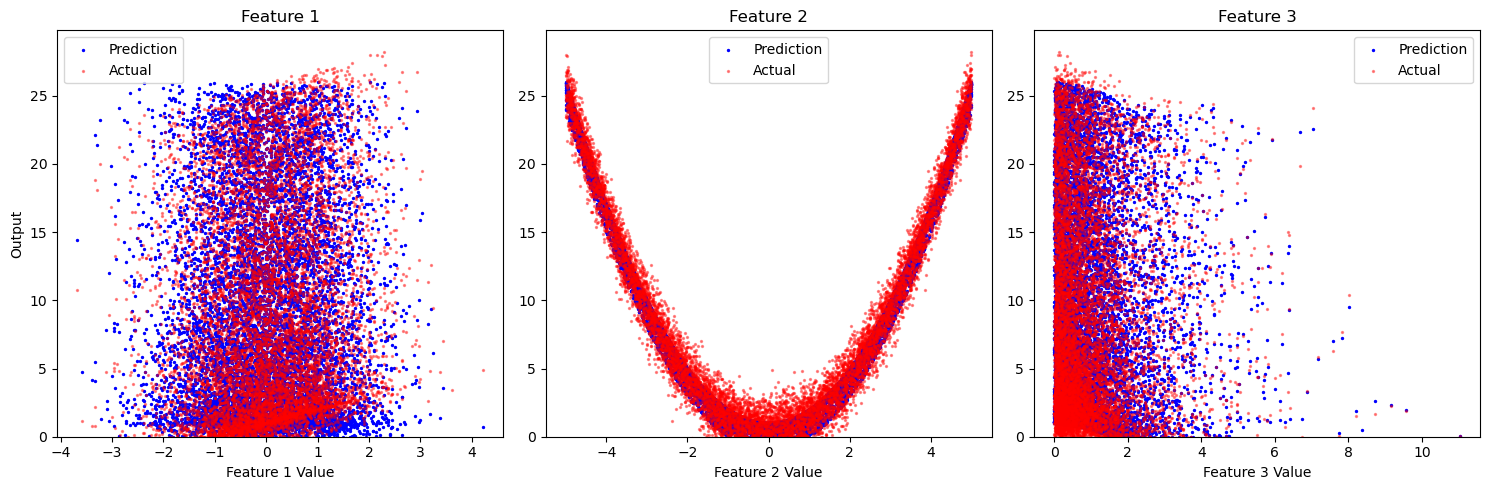

In [ ]:
import matplotlib.pyplot as plt

x = decode(min_for, features.to(device))
print(criterion(x.squeeze(1).requires_grad_(), labels.to(device)).detach().cpu())
x = x.detach().cpu()
print(features.shape)

# Creating a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
size = 2
alpha = 0.4
# Assuming features has at least 3 columns
# Adjust the indices as needed to plot different features

# Scatter plot for feature 1
axes[0].scatter(features[:, 0], x, color="blue", label='Prediction', s=size)
axes[0].scatter(features[:, 0], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[0].set_title('Feature 1')
axes[0].set_xlabel('Feature 1 Value')
axes[0].set_ylabel('Output')
axes[0].set_ylim(0)
axes[0].legend()

# Scatter plot for feature 2
axes[1].scatter(features[:, 1], x, color="blue", label='Prediction', s=size)
axes[1].scatter(features[:, 1], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[1].set_title('Feature 2')
axes[1].set_xlabel('Feature 2 Value')
axes[1].set_ylim(0)
axes[1].legend()

# Scatter plot for feature 3
axes[2].scatter(features[:, 2], x, color="blue", label='Prediction', s=size)
axes[2].scatter(features[:, 2], labels, color="red", label='Actual', s=size, alpha=alpha)
axes[2].set_title('Feature 3')
axes[2].set_xlabel('Feature 3 Value')
axes[2].set_ylim(0)
axes[2].legend()


# Adjust the layout
plt.tight_layout()
plt.show()


In [ ]:
#torch.save(model, 'model.pth')